In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Machine learning to predict age from rs-fmri

The goal is to extract data from several rs-fmri images, and use that data as features in a machine learning model. We will integrate what we've learned in the previous machine learning lecture to build an unbiased model and test it on a left out sample.

Link to slides: https://figshare.com/s/4d9953055c9ed36301ad#/articles/9162428

## Load the data

<img src="Imgs/SampFeat.png" alt="terms" width="300"/>


In [3]:
# change this to the location where you downloaded the data
wdir = '/users/isabellesimard2/Documents/BrainHack_School_2019/osfstorage-archive/'


In [4]:
# Now fetch the data

from glob import glob
import os
data = sorted(glob(os.path.join(wdir,'*.gz')))
confounds = sorted(glob(os.path.join(wdir,'*regressors.tsv')))

How many individual subjects do we have?

In [5]:
#len(data.func)
len(data)

155

## Extract features

![feat_xtrct](https://ars.els-cdn.com/content/image/1-s2.0-S1053811919301594-gr1.jpg)

In order to do our machine learning, we will need to extract feature from our rs-fmri images.

Specifically, we will extract signals from a brain parcellation and compute a correlation matrix, representing regional coactivation between regions.

We will practice on one subject first, then we'll extract data for all subjects

#### Retrieve the atlas for extracting features and an example subject

Since we're using rs-fmri data, it makes sense to use an atlas defined using rs-fmri data

This paper has many excellent insights about what kind of atlas to use for an rs-fmri machine learning task. See in particular Figure 5.

https://www.sciencedirect.com/science/article/pii/S1053811919301594?via%3Dihub

Let's use the MIST atlas, created here in Montreal using the BASC method. This atlas has multiple resolutions, for larger networks or finer-grained ROIs. Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable

Here is a link to the MIST paper: https://mniopenresearch.org/articles/1-3

In [6]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

/Users/isabellesimard2/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Atlas ROIs are located in nifti image (4D) at: /Users/isabellesimard2/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

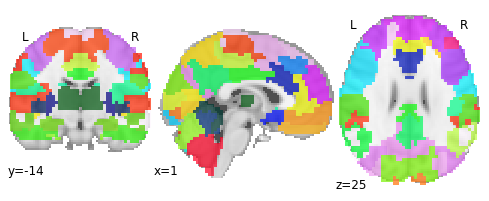

In [7]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

Great, let's load an example 4D fmri time-series for one subject

In [8]:
fmri_filenames = data[0]
print(fmri_filenames)

/users/isabellesimard2/Documents/BrainHack_School_2019/osfstorage-archive/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Let's have a look at the image! Because it is a 4D image, we can only look at one slice at a time. Or, better yet, let's look at an average image!

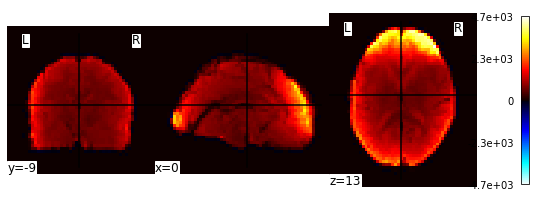

In [9]:
from nilearn import image 

averaged_Img = image.mean_img(image.mean_img(fmri_filenames))
plotting.plot_stat_map(averaged_Img)

#### Extract signals on a parcellation defined by labels
Using the NiftiLabelsMasker

So we've loaded our atlas and 4D data for a single subject. Let's practice extracting features!


In [10]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=1)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
conf = confounds[0]
time_series = masker.fit_transform(fmri_filenames, confounds=conf)

[NiftiLabelsMasker.fit_transform] loading data from /Users/isabellesimard2/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


So what did we just create here?

In [11]:
type(time_series)

numpy.ndarray

In [12]:
time_series.shape
#time_series.mean(0).shape
#to compute mean activity 

(168, 64)

What are these "confounds" and how are they used? 

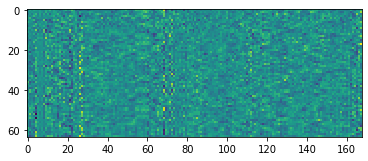

In [13]:
import matplotlib.pyplot as plt
plt.imshow(time_series.T)





In [14]:
import pandas
conf_df = pandas.read_table(conf)
conf_df.head()

,csf,white_matter,global_signal,std_dvars,dvars,framewise_displacement,t_comp_cor_00,t_comp_cor_01,t_comp_cor_02,t_comp_cor_03,...,cosine00,cosine01,cosine02,cosine03,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,818.550141,875.069943,1262.020140,0.000000,0.000000,0.000000,-0.020679,-0.033857,0.095524,-0.022131,...,0.109104,0.109090,0.109066,0.109033,0.013422,-0.235811,0.033243,-0.000900,-9.976860e-24,0.000152
1,815.643544,873.886244,1260.829698,1.320145,37.240650,0.124271,-0.007043,-0.045004,-0.032265,-0.000439,...,0.109066,0.108937,0.108723,0.108423,0.030943,-0.238651,0.088048,-0.001747,-1.329770e-04,0.000154
2,820.769909,872.997093,1262.678653,1.299640,36.662231,0.052546,-0.005027,-0.089152,-0.052859,-0.083313,...,0.108990,0.108632,0.108038,0.107207,0.012759,-0.230284,0.097429,-0.001644,-0.000000e+00,0.000250
3,816.815767,872.913170,1261.592396,1.540568,43.458698,0.100117,0.053507,-0.081439,0.029216,-0.002027,...,0.108875,0.108176,0.107012,0.105391,0.010014,-0.213517,0.143186,-0.001455,9.294130e-05,0.000665
4,818.287589,872.019839,1249.983704,2.743071,77.380722,0.272004,0.025015,-0.061691,0.023856,-0.159531,...,0.108723,0.107567,0.105651,0.102986,0.059444,-0.259451,0.083982,-0.000378,3.686370e-04,0.001661


In [15]:
conf_df.shape

(168, 28)

#### Compute and display a correlation matrix


In [16]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

Plot the correlation matrix

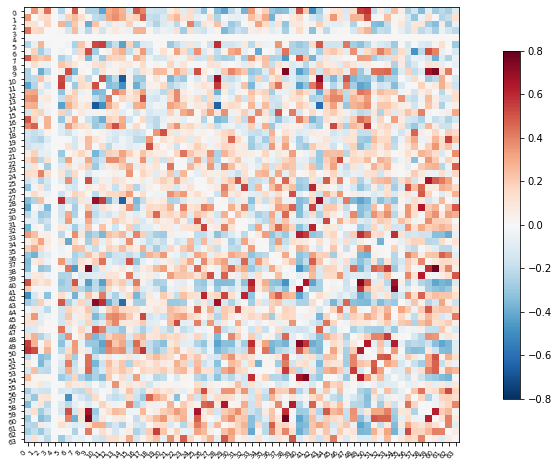

In [17]:
import numpy as np
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

#### Extract FNC features from the whole dataset

Here, we are going to use a for loop to iterate through each image and use the same techniques we learned above to extract rs-fmri connectivity features from every subject.



In [18]:
# # Here is a really simple for loop

# for i in range(10):
#     print('the number is', i)

In [19]:
# container = []
# for i in range(10):
#     container.append(i)

# container

Now lets construct a more complicated loop to do what we want

First we do some things we don't need to do in the loop. Let's reload our atlas, and re-initiate our masker and correlation_measure

In [20]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

Okay -- now that we have that taken care of, let's run our big loop!

**NOTE**: On a laptop, this might a few minutes.

In [21]:
all_features_FNC = [] # here is where we will put the data (a container)

for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

    # add to our container
    all_features_FNC.append(correlation_matrix)

    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [22]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('MAIN_BASC064_subsamp_features_FNC',a = all_features_FNC)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [23]:
feat_file = 'MAIN_BASC064_subsamp_features_FNC.npz'
X_features_FNC = np.load(feat_file)['a']

In [24]:
X_features_FNC.shape

(155, 2016)

<img src="Imgs/SampFeat.png" alt="terms" width="300"/>

Okay so we've got our features.

We can visualize our feature matrix

Text(0, 0.5, 'subjects')

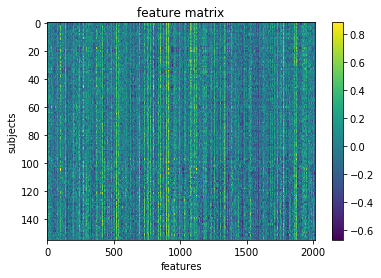

In [25]:
import matplotlib.pyplot as plt

plt.imshow(X_features_FNC, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

#### Extract Spatial Maps features from the whole dataset

In [26]:
all_features_SpatialMaps = [] # here is where we will put the data (a container)

for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=confounds[i])
    flattened_TA = time_series.flatten ()
    # add to our container
    all_features_SpatialMaps.append(flattened_TA)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [27]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('MAIN_BASC064_subsamp_features_Neural_Activity',a = all_features_SpatialMaps)

In [28]:
feat_file = 'MAIN_BASC064_subsamp_features_Neural_Activity.npz'
X_features_SpatialMaps = np.load(feat_file)['a']

In [29]:
X_features_SpatialMaps.shape

(155, 10752)

In [30]:
X_features_SpatialMaps.reshape(-1)

array([-1.06764824, -0.09106132, -1.17865657, ...,  1.08802921,
        3.20724999, -2.23727303])

Text(0, 0.5, 'subjects')

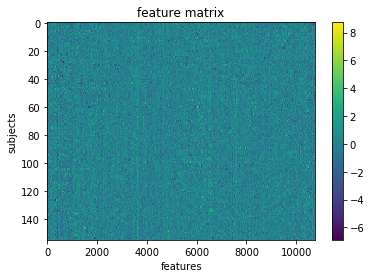

In [31]:
import matplotlib.pyplot as plt

plt.imshow(X_features_SpatialMaps, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

#### Compute fALFF features from the whole dataset

In [32]:
from nilearn.input_data import NiftiLabelsMasker
#from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
#correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                      #   discard_diagonal=True)

In [33]:
import fALFF
all_features_fALFF = [] # here is where we will put the data (a container)
#So I could put the metrics in different containers or append them
for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=confounds[i])
    my_fALFF = fALFF.create_falff(time_series)
    
    # add to our container
    all_features_fALFF.append(my_fALFF)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [34]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('MAIN_BASC064_subsamp_features_fALFF',a = all_features_fALFF)

In [35]:
feat_file = 'MAIN_BASC064_subsamp_features_fALFF.npz'
X_features_fALFF = np.load(feat_file)['a']

In [36]:
X_features_fALFF.shape

(155, 64)

Text(0, 0.5, 'subjects')

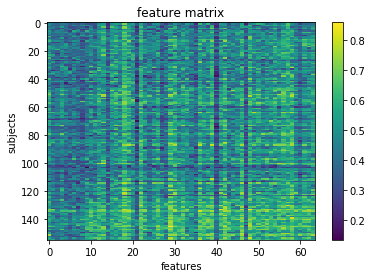

In [37]:
import matplotlib.pyplot as plt

plt.imshow(X_features_fALFF, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Create ensemble features of combined metrics for the whole dataset

In [80]:
X_features_ensemble = np.concatenate((all_features_FNC, all_features_SpatialMaps, all_features_fALFF), axis=1)


In [81]:
X_features_ensemble

array([[ 0.34525799,  0.1096033 ,  0.11469795, ...,  0.46610389,
         0.42369552,  0.54418491],
       [ 0.35540265, -0.01412368,  0.17411362, ...,  0.38534957,
         0.38722524,  0.40166128],
       [ 0.39995242,  0.07326978,  0.05982696, ...,  0.45183376,
         0.46134101,  0.438243  ],
       ...,
       [ 0.21353003,  0.00650016,  0.06002305, ...,  0.41870039,
         0.50835651,  0.48247871],
       [ 0.40077139, -0.04117217,  0.14502947, ...,  0.64612601,
         0.70453936,  0.51472557],
       [ 0.21433394, -0.06941109,  0.03236305, ...,  0.54820145,
         0.56782611,  0.54664512]])

In [82]:
X_features_ensemble.shape

(155, 12832)

Text(0, 0.5, 'subjects')

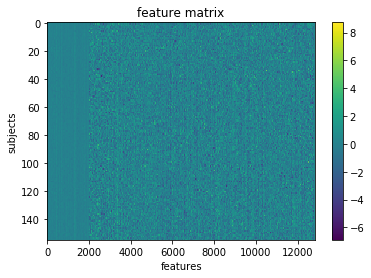

In [83]:
import matplotlib.pyplot as plt

plt.imshow(X_features_ensemble, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

## Get Y (our target) and assess its distribution

In [38]:
# Let's load the phenotype data

pheno_path = os.path.join(wdir, 'participants.tsv')

In [39]:
import pandas

pheno = pandas.read_csv(pheno_path, sep='\t').sort_values('participant_id')
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
4,sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


Looks like there is a column labeling age. Let's capture it in a variable

In [40]:
y_age = pheno['Age']

Maybe we should have a look at the distribution of our target variable

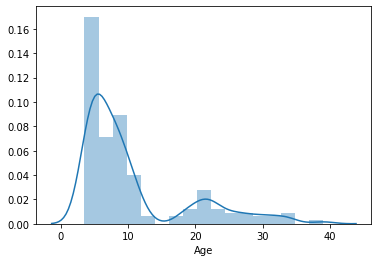

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(y_age)

## Prepare data for machine learning FNC

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "validation" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". This dataset has a variable indicating AgeGroup. We can use that to make sure our training and testing sets are balanced!

In [42]:
age_class = pheno['AgeGroup']
age_class.value_counts()

8-12yo    34
5yo       34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

In [43]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train_FNC, X_val_FNC, y_train_FNC, y_val_FNC = train_test_split(
                                                    X_features_FNC, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_FNC),
     'testing:', len(X_val_FNC))

training: 93 testing: 62


Let's visualize the distributions to be sure they are matched

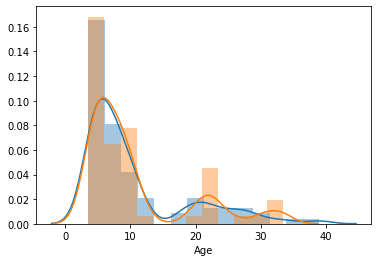

In [45]:
sns.distplot(y_train_FNC)
sns.distplot(y_val_FNC)

## Prepare data for machine learning Spatial Maps

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "validation" sample that we will not touch until the end

In [46]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train_SM, X_val_SM, y_train_SM, y_val_SM = train_test_split(
                                                    X_features_SpatialMaps, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_SM),
     'testing:', len(X_val_SM))

training: 93 testing: 62


## Prepare data for machine learning fALFF

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "validation" sample that we will not touch until the end

In [48]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train_falff, X_val_falff, y_train_falff, y_val_falff = train_test_split(
                                                    X_features_fALFF, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_falff),
     'testing:', len(X_val_falff))

training: 93 testing: 62


### Prepare data for machine learning Combined metrics
Here, we will define a "training sample" where we can play around with our models. We will also set aside a "validation" sample that we will not touch until the end

In [84]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
                                                    X_features_ensemble, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_all),
     'testing:', len(X_val_all))

training: 93 testing: 62


## Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a fairly standard regression model called a Support Vector Regressor (SVR). 

While this may seem unambitious, simple models can be very robust. And we probably don't have enough data to create more complex models (but we can try later).

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

In [49]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear') # define the model


#l_svr.fit(X_train, y_train) # fit the model

Well... that was easy. Let's see how well the model learned the data!


<img src="Imgs/modval.png" alt="terms" width="800"/>

### Test split: FNC

In [51]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 75/25 ratio, and 
# stratify by age class, and also shuffle the data.

age_class2 = pheno.loc[y_train_FNC.index,'AgeGroup']

X_train2_FNC, X_test_FNC, y_train2_FNC, y_test_FNC = train_test_split(
                                                    X_train_FNC, # x
                                                    y_train_FNC, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class2,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train2_FNC),
     'testing:', len(X_test_FNC))

training: 69 testing: 24


In [52]:
from sklearn.metrics import mean_absolute_error

# # fit model just to training data
# l_svr.fit(X_train2,y_train2)

# # predict the *test* data based on the model trained on X_train2
# y_pred = l_svr.predict(X_test) 

# # caluclate the model accuracy
# acc = l_svr.score(X_test, y_test) 
# mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

In [53]:
# # print results
# print('accuracy (R2) = ', acc)
# print('MAE = ',mae)

# sns.regplot(y_pred,y_test)
# plt.xlabel('Predicted Age')

Not perfect, but as predicting with unseen data goes, not too bad! Especially with a training sample of "only" 69 subjects. But we can do better! 

For example, we can increase the size our training set while simultaneously reducing bias by instead using 10-fold cross-validation

<img src="Imgs/KCV.png" alt="terms" width="500"/>

In [54]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# # predict
# y_pred = cross_val_predict(l_svr, X_train, y_train, cv=10)
# # scores
# acc = cross_val_score(l_svr, X_train, y_train, cv=10)
# mae = cross_val_score(l_svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

We can look at the accuracy of the predictions for each fold of the cross-validation

In [55]:
# for i in range(10):
#     print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i],-mae[i]))

We can also look at the overall accuracy of the model

In [56]:
from sklearn.metrics import r2_score

# overall_acc = r2_score(y_train, y_pred)
# overall_mae = mean_absolute_error(y_train,y_pred)
# print('R2:',overall_acc)
# print('MAE:',overall_mae)

# sns.regplot(y_pred, y_train)
# plt.xlabel('Predicted Age')

Not too bad at all! But more importantly, this is a more accurate estimation of our model's predictive efficacy. Our sample size is larger and this is based on several rounds of prediction of unseen data. 

For example, we can now see that the effect is being driven by the model's successful parsing of adults vs. children, but is not performing so well within the adult or children group. This was not evident during our previous iteration of the model

## Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's fine to try out different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

It is not uncommon to try other models, or tweak hyperparameters. In this case, due to our relatively small sample size, we are probably not powered sufficiently to do so, and we would once again risk overfitting. However, for the sake of demonstration, we will do some tweaking. 

<img src="Imgs/KCV2.png" alt="terms" width="500"/>


We will try a few different examples:
* Normalizing our target data
* Tweaking our hyperparameters
* Trying a more complicated model
* Feature selection

#### Normalize the target data: FNC

Text(0.5, 1.0, 'Log-Transformed Age FNC')

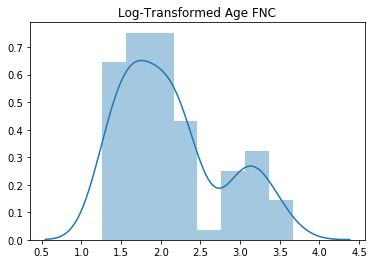

In [59]:
# Create a log transformer function and log transform Y (age)

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train_FNC.values.reshape(-1,1))
y_train_log_FNC = log_transformer.transform(y_train_FNC.values.reshape(-1,1))[:,0]

sns.distplot(y_train_log_FNC)
plt.title("Log-Transformed Age FNC")

#### Normalize the target data: Spatial Maps

Text(0.5, 1.0, 'Log-Transformed Age Spatial Maps')

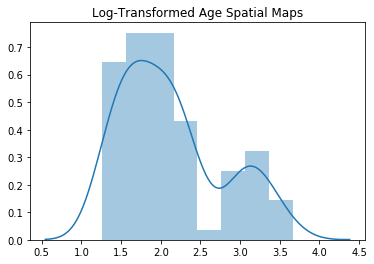

In [60]:
# Create a log transformer function and log transform Y (age)

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train_SM.values.reshape(-1,1))
y_train_log_SM = log_transformer.transform(y_train_SM.values.reshape(-1,1))[:,0]

sns.distplot(y_train_log_SM)
plt.title("Log-Transformed Age Spatial Maps")

#### Normalize the target data: fALFF

Text(0.5, 1.0, 'Log-Transformed Age fALFF')

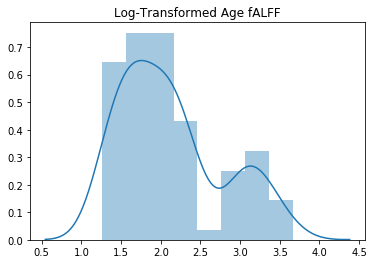

In [61]:
# Create a log transformer function and log transform Y (age)

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train_falff.values.reshape(-1,1))
y_train_log_falff = log_transformer.transform(y_train_falff.values.reshape(-1,1))[:,0]

sns.distplot(y_train_log_falff)
plt.title("Log-Transformed Age fALFF")

#### Normalize the target data: Combined metrics

Text(0.5, 1.0, 'Log-Transformed Age Combined model')

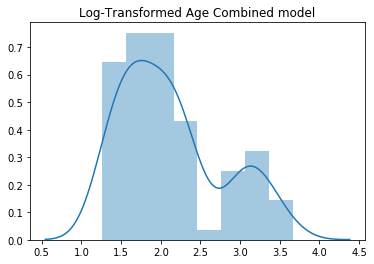

In [85]:
# Create a log transformer function and log transform Y (age)

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train_all.values.reshape(-1,1))
y_train_log_all = log_transformer.transform(y_train_all.values.reshape(-1,1))[:,0]

sns.distplot(y_train_log_all)
plt.title("Log-Transformed Age Combined model")

Now let's go ahead and cross-validate our model once again with this new log-transformed target

FNC model
R2: 0.7196967972989133
MAE: 0.2725497017161002
Spatial Maps model
R2: 0.4008224272408131
MAE: 0.3917998405840568
fALFF model
R2: 0.5349459688052945
MAE: 0.3359584675122863
Combined Metrics model
R2: 0.409756943211264
MAE: 0.38892004559661986


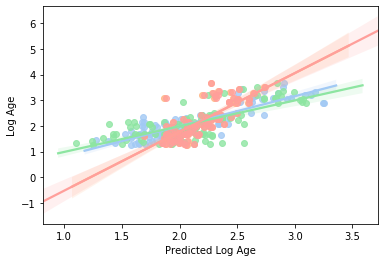

In [92]:
# predict FNC model
y_pred_FNC = cross_val_predict(l_svr, X_train_FNC, y_train_log_FNC, cv=10)

# predict Spatial Maps model
y_pred_SM = cross_val_predict(l_svr, X_train_SM, y_train_log_SM, cv=10)

# predict fALFF model
y_pred_falff = cross_val_predict(l_svr, X_train_falff, y_train_log_falff, cv=10)

# predict Combined Metrics model
y_pred_all = cross_val_predict(l_svr, X_train_all, y_train_log_all, cv=10)

# scores FNC
acc_FNC = r2_score(y_train_log_FNC, y_pred_FNC)
mae_FNC = mean_absolute_error(y_train_log_FNC,y_pred_FNC)

# scores Spatial Maps
acc_SM = r2_score(y_train_log_SM, y_pred_SM)
mae_SM = mean_absolute_error(y_train_log_SM,y_pred_SM)

# scores fALFF
acc_falff = r2_score(y_train_log_falff, y_pred_falff)
mae_falff = mean_absolute_error(y_train_log_falff,y_pred_falff)

# scores Combined metrics
acc_all = r2_score(y_train_log_all, y_pred_all)
mae_all = mean_absolute_error(y_train_log_all,y_pred_all)

sns.set_palette("pastel")

print('FNC model')
print('R2:',acc_FNC)
print('MAE:',mae_FNC)

sns.regplot(y_pred_FNC, y_train_log_FNC)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

print('Spatial Maps model')
print('R2:',acc_SM)
print('MAE:',mae_SM)

sns.regplot(y_pred_SM, y_train_log_SM)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

print('fALFF model')
print('R2:',acc_falff)
print('MAE:',mae_falff)

sns.regplot(y_pred_falff, y_train_log_falff)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

print('Combined Metrics model')
print('R2:',acc_all)
print('MAE:',mae_all)

sns.regplot(y_pred_all, y_train_log_all)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

plt.savefig('All_models_Train_Model_Log_Age.png')

## Can our model predict age in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode age based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a log transformation on our training data, we will need to transform our testing data using the *same information!*  But that's easy because we stored our transformation in an object!


In [93]:
# Notice how we use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
y_val_log_FNC = log_transformer.transform(y_val_FNC.values.reshape(-1,1))[:,0]
y_val_log_SM = log_transformer.transform(y_val_SM.values.reshape(-1,1))[:,0]
y_val_log_falff = log_transformer.transform(y_val_falff.values.reshape(-1,1))[:,0]
y_val_log_all = log_transformer.transform(y_val_all.values.reshape(-1,1))[:,0]

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

In [65]:
# l_svr.fit(X_train, y_train_log) # fit to training data
# y_pred = l_svr.predict(X_val) # classify age class using testing data
# acc = l_svr.score(X_val, y_val_log) # get accuracy (r2)
# mae = mean_absolute_error(y_val_log, y_pred) # get mae

# # print results
# print('accuracy (r2) =', acc)
# print('mae = ',mae)

# # plot results
# sns.regplot(y_pred, y_val_log)
# plt.xlabel('Predicted Log Age')
# plt.ylabel('Log Age')

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

The proper thing to do at this point would be to repeat the train-validation split multiple times. This will ensure the results are not specific to this validation set, and will give you some confidence intervals around your results.

As an assignment, you can give that a try below. Create 10 different splits of the entire dataset, fit the model and get your predictions. Then, plot the range of predictions.


Results FNC model
accuracy (r2) = 0.7885966918785823
mae =  0.2947102241055258
Results Neural Activity model
accuracy (r2) = 0.529873704445296
mae =  0.37794835614610983
Results fALFF model
accuracy (r2) = 0.25945625325246713
mae =  0.44235834311594024
Results Combined Metrics model
accuracy (r2) = 0.5374712444231904
mae =  0.37640414759817015


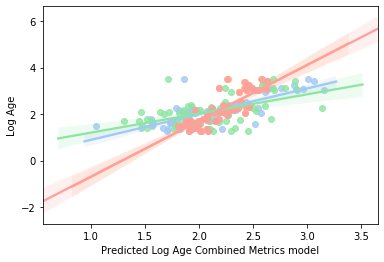

In [94]:
from sklearn.model_selection import cross_val_predict, cross_val_score

#Test FNC model on useen data
l_svr.fit(X_train_FNC, y_train_log_FNC) # fit to training data
y_pred_FNC = cross_val_predict(l_svr, X_val_FNC, y_val_log_FNC, cv=10) # classify age class using testing data
acc_FNC = l_svr.score(X_val_FNC, y_val_log_FNC) # get accuracy (r2)
mae_FNC = mean_absolute_error(y_val_log_FNC, y_pred_FNC) # get mae

#Test Spatial Maps model on useen data
l_svr.fit(X_train_SM, y_train_log_SM) # fit to training data
y_pred_SM = cross_val_predict(l_svr, X_val_SM, y_val_log_SM, cv=10) # classify age class using testing data
acc_SM = l_svr.score(X_val_SM, y_val_log_SM) # get accuracy (r2)
mae_SM = mean_absolute_error(y_val_log_SM, y_pred_SM) # get mae

#Test fALFF model on useen data
l_svr.fit(X_train_falff, y_train_log_falff) # fit to training data
y_pred_falff = cross_val_predict(l_svr, X_val_falff, y_val_log_falff, cv=10) # classify age class using testing data
acc_falff = l_svr.score(X_val_falff, y_val_log_falff) # get accuracy (r2)
mae_falff = mean_absolute_error(y_val_log_falff, y_pred_falff) # get mae

#Test Combined Metrics model on useen data
l_svr.fit(X_train_all, y_train_log_all) # fit to training data
y_pred_all = cross_val_predict(l_svr, X_val_all, y_val_log_all, cv=10) # classify age class using testing data
acc_all = l_svr.score(X_val_all, y_val_log_all) # get accuracy (r2)
mae_all = mean_absolute_error(y_val_log_all, y_pred_all) # get mae

# print results FNC model
print('Results FNC model')
print('accuracy (r2) =', acc_FNC)
print('mae = ',mae_FNC)

# print results Spatial Maps model
print('Results Neural Activity model')
print('accuracy (r2) =', acc_SM)
print('mae = ',mae_SM)

# print results fALFF model
print('Results fALFF model')
print('accuracy (r2) =', acc_falff)
print('mae = ',mae_falff)

# print results Combined Metrics model
print('Results Combined Metrics model')
print('accuracy (r2) =', acc_all)
print('mae = ',mae_all)

# plot results FNC
sns.regplot(y_pred_FNC, y_val_log_FNC)
plt.xlabel('Predicted Log Age FNC model')
plt.ylabel('Log Age')

# plot results Spatial Maps
sns.regplot(y_pred_SM, y_val_log_SM)
plt.xlabel('Predicted Log Age Neural Activity model')
plt.ylabel('Log Age')

# plot results fALFF
sns.regplot(y_pred_falff, y_val_log_falff)
plt.xlabel('Predicted Log Age fALFF model')
plt.ylabel('Log Age')

# plot results Combined Metrics
sns.regplot(y_pred_all, y_val_log_all)
plt.xlabel('Predicted Log Age Combined Metrics model')
plt.ylabel('Log Age')
plt.savefig('All_Metrics_Validate_Model_Log_Age.png')

Now lets try an ensemble model to compare the performance of the combined models using all 3 metrics of resting-state activity

In [74]:
# #not working because x varies across models
# from sklearn import datasets
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier

# combined = VotingClassifier(estimators=[('FNC', y_pred_FNC), ('SM', y_pred_SM), ('fALFF', y_pred_falff)], voting='hard')

# for clf, label in zip([y_pred_FNC, y_pred_SM, y_pred_falff, combined], ['Functional Connectivity', 'Spatial Maps', 'fALFF', 'Ensemble']):
#      scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
#      print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

NameError: name 'X' is not defined

So, it seems like something in this data does seem to be systematically related to age ... but what?  

#### Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models. 

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances. While we can't ascribe any biological relevance to the features, it can still be helpful to know what the model is using to make its predictions. This is a good way to, for example, establish whether your model is actually learning based on a confound! Could you think of some examples?

We can access the feature importances (weights) used my the model

In [ ]:
l_svr.coef_

lets plot these weights to see their distribution better

In [ ]:
plt.bar(range(l_svr.coef_.shape[-1]),l_svr.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

We can use the correlation measure from before to perform an inverse transform

In [ ]:
correlation_measure.inverse_transform(l_svr.coef_).shape

In [ ]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(l_svr.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8),  
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [ ]:
coords = plotting.find_parcellation_cut_coords(atlas_filename)

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

In [ ]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True)

Whoa!! That's...a lot to process. Maybe let's threshold the edges so that only the most important connections are visualized

In [ ]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.035)

That's definitely an improvement, but it's still a bit hard to see what's going on.
Nilearn has a new feature that let's use view this data interactively!

In [ ]:
plotting.view_connectome(feat_exp_matrix, coords, threshold='98%')